In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os

import numpy as np
from numba import njit, prange
from scipy.spatial.transform import Rotation as rot
from scipy.ndimage import zoom

import astropy.units as u
from astropy.visualization import quantity_support

quantity_support()

%matplotlib widget

figsize=(12,7)

In [22]:
@njit(parallel=True)
def circ_mask(image_w, image_h, N_side, center, radius):
    x_res = image_w / N_side
    y_res = image_h / N_side
    src = np.ones((N_side, N_side))
    for i in prange(N_side):
        for j in prange(N_side):
            if np.sqrt((i * x_res - center[0])**2 + (j * y_res - center[1])**2) > radius:
                src[i][j] = 0
    return src

45


## Parse Zemax output files

### Input source parameters

In [23]:
# mapping of surface number to name
important_keys = {
    0: 'Beam origin',
    11: 'Zotefoam',
    16: 'p2',
    24: 'p1',
    27: 'f1',
    31: 'k3',
    34: 'k2',
    37: 'k1',
    39: 'flange',
    40: 'cabin floor',
}
surf_numbers = {
    'Beam origin': 0,
    'Zotefoam': 11,
    'p2': 16,
    'p1': 24,
    'f1': 27,
    'k3': 31,
    'k2': 34,
    'k1': 37,
    'flange': 39,
    'cabin floor': 40,
}

In [24]:
src_surf_name = 'p2'
src_zoom = 3
dest_surf_name = 'p1'
dest_zoom = 1

# TODO: get f1 sag
# TODO: get f1 launch prop report
# TODO: get k3 sag
# TODO: get k1 sag
# TODO: get flange sag?

48


(768, 768)


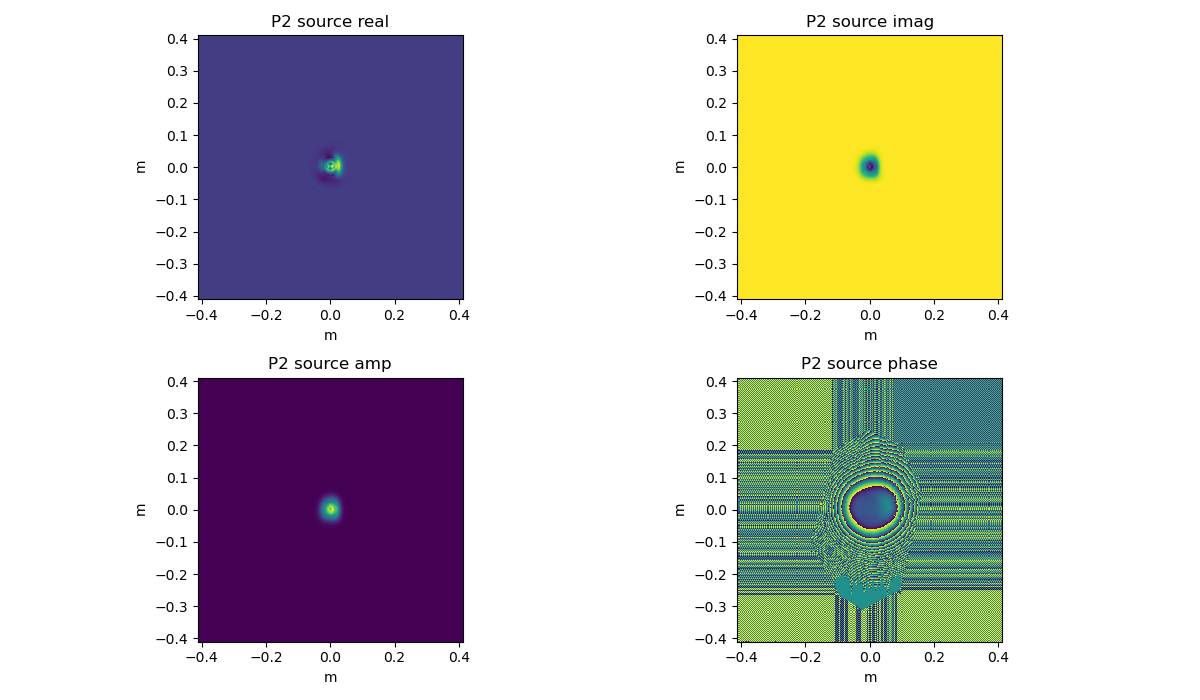

In [25]:
# irradiance and phase data from POP beamfiles to a surface are output as arrays in a plane
# propagating along the chief ray, with x,y axes perpendicular to it with some rotation.
# The POP simulation starts at the same point every time, and terminates on a given surface.
# From this surface, we export the POP data as a text file.
# We take this text file as the illumination for the next surface.
direc = '/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/'
amp_file = src_surf_name + '_launch_irr.txt'
phase_file = src_surf_name + '_launch_phase.txt'
src_amp = np.genfromtxt(direc + amp_file, skip_header=15, encoding='utf-16')
src_phase = np.genfromtxt(direc + phase_file, skip_header=15, encoding='utf-16')
src = src_amp * np.cos(src_phase) + 1j * src_amp * np.sin(src_phase)

# up/downsample src beamfile
src = zoom(src, src_zoom)
print(src.shape)

assert(src.shape[0] == src.shape[1]), "Non-square input data!"
N = src.shape[0]

lambda_query = "Beam wavelength is "
shape_query = "Display X "
with open(direc + amp_file, encoding='utf-16') as f:
    for line in f.readlines():
        if line.startswith(lambda_query):
            lambd = float(line.lstrip(lambda_query).split()[0])
        if line.startswith(shape_query):
            parts = line.lstrip(shape_query).split()
            src_width = float(parts[2].rstrip(','))
            src_height = float(parts[-2].rstrip(','))
lambd = (lambd * u.micron).to(u.m)
src_width = (src_width * u.mm).to(u.m)
src_height = (src_height * u.mm).to(u.m)

# src = circ_mask(src_width, src_height, N, (src_width / 2., src_height / 2.), src_width / 16.)

xs = np.linspace(-src_width / 2, src_width / 2, N)
ys = np.linspace(-src_height / 2, src_height / 2, N)
xx, yy = np.meshgrid(xs, ys)
zz = np.zeros_like(xx)

fig, ax = plt.subplots(figsize=figsize, nrows=2, ncols=2)
ax[0,0].pcolormesh(xx, yy, (src.real))
ax[0,0].set_aspect('equal')
ax[0,0].set_title(f'{src_surf_name.upper()} source real')
ax[0,1].pcolormesh(xx, yy, (src.imag))
ax[0,1].set_aspect('equal')
ax[0,1].set_title(f'{src_surf_name.upper()} source imag')

ax[1,0].pcolormesh(xx, yy, np.abs(src))
ax[1,0].set_aspect('equal')
ax[1,0].set_title(f'{src_surf_name.upper()} source amp')
ax[1,1].pcolormesh(xx, yy, np.angle(src))
ax[1,1].set_aspect('equal')
ax[1,1].set_title(f'{src_surf_name.upper()} source phase')
fig.tight_layout()

### Construct the location of each source point in the frame of the beamfile

In [26]:
src_coords = np.zeros((xx.shape[0] * xx.shape[1], 3))
xx_f = xx.flatten()
yy_f = yy.flatten()
zz_f = zz.flatten()
for i in range(src_coords.shape[0]):
    src_coords[i][0] = xx_f[i].value
    src_coords[i][1] = yy_f[i].value
    src_coords[i][2] = zz_f[i].value

### Load in sag data

dz shape: 0.6 m 0.6 m (129, 129)


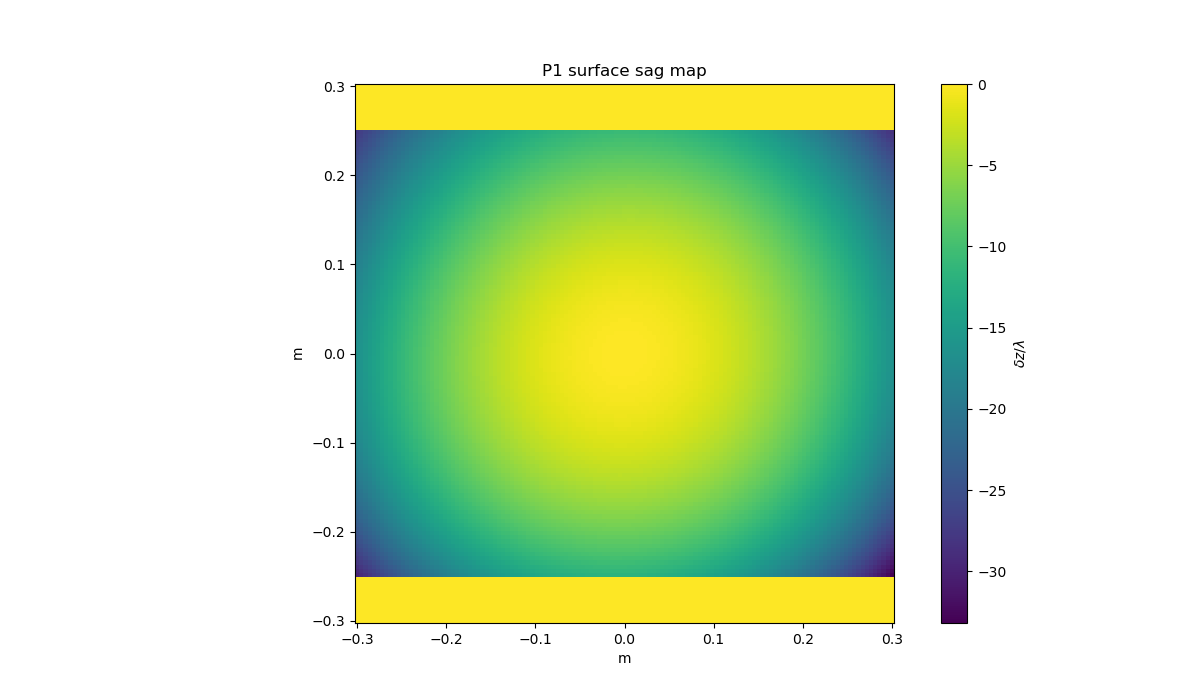

In [27]:
# If a surface has some curvature, we can export it as a text file from the surface's sag report.
sag_file = dest_surf_name + '_sag.txt'
if os.path.exists(direc + sag_file):
    # parse sag array from file
    dz = (np.genfromtxt(direc + sag_file, skip_header=15, encoding='utf-16') * u.mm).to(u.m)
    assert(dz.shape[0] == dz.shape[1]), "Non-square sag data!"
    # parse optic shape from file
    width_query = "Width = "
    with open(direc + sag_file, encoding='utf-16') as f:
        for line in f.readlines():
            if line.startswith(width_query):
                sag_width = float(line.lstrip(width_query).split(',')[0])
    sag_width = (sag_width * u.mm).to(u.m)
    sag_height = sag_width
elif dest_surf_name == 'f1':
    sag_width = (18.110 * u.imperial.inch).to(u.m)
    sag_height = (31.496 * u.imperial.inch).to(u.m)
    dz = np.zeros((129,129)) * u.m
elif dest_surf_name == 'k3':
    sag_width = (21.654 * u.imperial.inch).to(u.m)
    sag_height = (29.528 * u.imperial.inch).to(u.m)
    dz = np.zeros((129,129)) * u.m
elif dest_surf_name == 'k1':
    sag_width = (18.110 * u.imperial.inch).to(u.m)
    sag_height = (23.622 * u.imperial.inch).to(u.m)
    dz = np.zeros((129,129)) * u.m
elif dest_surf_name == 'flange':
    sag_width = (12. * u.imperial.inch).to(u.m)
    sag_height = sag_width
    dz = np.zeros((129,129)) * u.m
else:
    dz = 0

dz_min = dz.min()
dz_max = dz.max()

# up/downsample dest surface
dz = zoom(dz, dest_zoom) * u.m

print('dz shape:', sag_width, sag_height, dz.shape)

# fiducial: (0,0) dimple in dz
dz[0][0] += 0.05 * u.m

N_img = dz.shape[0]

xs_img = np.linspace(-sag_width / 2, sag_width / 2, N_img)
ys_img = np.linspace(-sag_height / 2, sag_height / 2, N_img)
xx_img, yy_img = np.meshgrid(xs_img, ys_img)

fig, ax = plt.subplots(figsize=figsize)
im = ax.pcolormesh(xx_img, yy_img, (dz / lambd).decompose(), vmin=dz_min / lambd, vmax=dz_max / lambd)
ax.set_title(f'{dest_surf_name.upper()} surface sag map')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax, label='$\delta z / \lambda$')

### Construct the location of each field point in the frame of the mirror

In [28]:
dest_coords = np.zeros((dz.shape[0] * dz.shape[1], 3))
xx_img_f = xx_img.flatten()
yy_img_f = yy_img.flatten()
dz_f = dz.flatten()
for i in range(dest_coords.shape[0]):
    dest_coords[i][0] = xx_img_f[i].value
    dest_coords[i][1] = yy_img_f[i].value
    dest_coords[i][2] = dz_f[i].value

### Parse propagation report

In order to get rotation matrices of beam axes relative to surface local axes.

In [29]:
# The POP propagation report tells us how the POP matrix axes are rotated as it
# bounces from surface to surface.
# At each surface, the POP matrix axes are perpendicular to the chief ray, 
# so there is one rotation matrix for before the beam hits the surface, and one for
# after it hits the surface and has the surface's transfer matrix applied to it.
# We take as source radiation input the "after" orientation of the surface 
# immediately preceding our destination surface of interest. 
beamfile_matrices = {}
surf_query = 'Surface transfer from before'
surf_num = -1
mat = []
togo = -1
with open(direc + src_surf_name + '_launch_prop_report.txt', encoding='utf-16') as f:
    for line in f.readlines():
        if line.startswith(surf_query):
            s = line.lstrip(surf_query)
            slist = s.split()
            surf_num = int(slist[-1])
        if line.startswith('Orientation matrix'):
            mat = []
            togo = 4
        if togo < 4 and togo > 0:
            mat.append([float(s) for s in line.lstrip().split()])
        elif togo == 0:
            if surf_num not in beamfile_matrices.keys():
                beamfile_matrices[surf_num] = [np.array(mat)] # "Before" matrix
            else:
                beamfile_matrices[surf_num].append(np.array(mat)) # "After" matrix
        togo -= 1

55


### Parse system prescription file report

In order to get rotation matrices of surface local axes relative to global frame.

In [30]:
# The system prescription report gives us the all-important rotation matrices
# and locations of each surface relative to whichever surface we have defined
# as the global origin.
global_matrices = {}
global_section_start_query = 'GLOBAL VERTEX COORDINATES, ORIENTATIONS, AND ROTATION/OFFSET MATRICES:'
global_section_end_query = 'GLOBAL SURFACE CENTER OF CURVATURE POINTS:'
global_section_skiplines = 7
surf_num = 0
mat = []
togo = -1
with open(direc + 'system_prescription.txt', encoding='utf-16') as f:
    # Skip all lines until we get to the global rotation matrix section.
    while global_section_start_query not in line:
        line = f.readline()
        continue
    # Skip until matrices start
    while global_section_skiplines:
        global_section_skiplines -= 1
        line = f.readline()
    # Read each matrix
    while global_section_end_query not in line:
        if not line.rstrip(): # skip empty lines between matrices
            line = f.readline()
            continue
        slist = line.split()
        if 5 < len(slist): # a line with a surface number, and maybe a label
            surf_num = int(slist[0])
            matline = slist[1:4]
            mat = []
            togo = 2
        else: # just matrix data
            matline = slist[:3]
        assert len(matline) == 3
        mat.append([float(val) for val in matline])
        if togo == 2:
            x = float(slist[4])
        elif togo == 1:
            y = float(slist[3])
        elif togo == 0: # save off matrix
            z = float(slist[3])
            global_matrices[surf_num] = [np.array(mat), (np.array([x,y,z]) * u.mm).to(u.m)]
        togo -= 1
        line = f.readline()

56


58


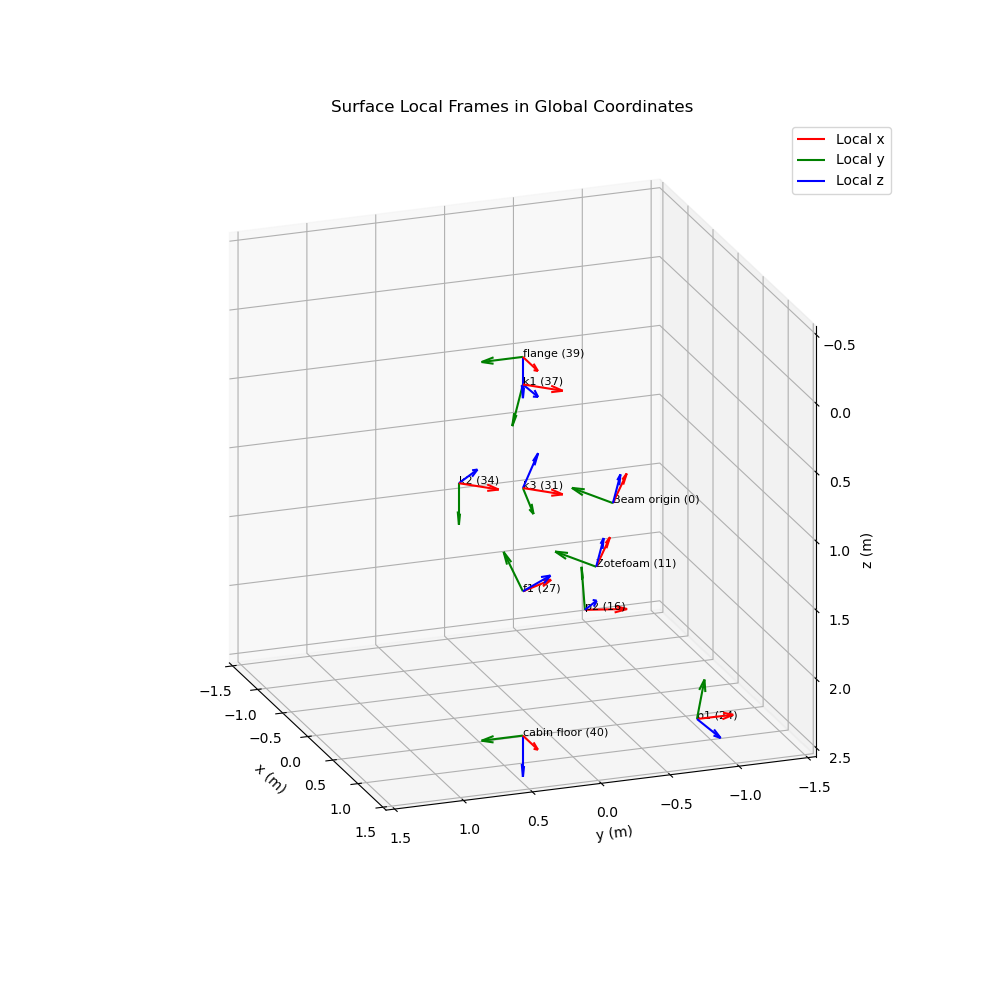

In [31]:
def plot_important_surfaces(global_matrices, important_keys):
    sz = .3
    first_time = True
    fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=1, subplot_kw={'projection':'3d'})
    for key in global_matrices.keys():
        if key in important_keys.keys():
            if first_time: # don't spam legends
                leg_mod = ''
            else:
                leg_mod = '_'
            ax.quiver3D(
                global_matrices[key][1][0],
                global_matrices[key][1][1],
                global_matrices[key][1][2],
                sz * global_matrices[key][0][0,0],
                sz * global_matrices[key][0][1,0],
                sz * global_matrices[key][0][2,0],
                color='red',
                label=leg_mod + 'Local x'
            )
            ax.quiver3D(
                global_matrices[key][1][0],
                global_matrices[key][1][1],
                global_matrices[key][1][2],
                sz * global_matrices[key][0][0,1],
                sz * global_matrices[key][0][1,1],
                sz * global_matrices[key][0][2,1],
                color='green',
                label=leg_mod + 'Local y'
            )
            ax.quiver3D(
                global_matrices[key][1][0],
                global_matrices[key][1][1],
                global_matrices[key][1][2],
                sz * global_matrices[key][0][0,2],
                sz * global_matrices[key][0][1,2],
                sz * global_matrices[key][0][2,2],
                color='blue',
                label=leg_mod + 'Local z'
            )
            ax.text(
                global_matrices[key][1][0].value,
                global_matrices[key][1][1].value,
                global_matrices[key][1][2].value,
                important_keys[key] + f' ({key})',
                fontsize=8
            )
            if first_time:
                first_time = False
    ax.legend(loc='best')

    ax.set_proj_type('ortho')
    ax.set_title('Surface Local Frames in Global Coordinates')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('z (m)')

    vbox_size = 3
    ax.set_xlim(-vbox_size / 2, vbox_size / 2)
    ax.set_ylim(-vbox_size / 2, vbox_size / 2)
    ax.set_zlim(np.array([-vbox_size / 2, vbox_size / 2]) + 1)
    ax.set_box_aspect([1,1,1])
    ax.view_init(azim=-160, elev=-160.)

    return fig, ax

fig, ax = plot_important_surfaces(global_matrices, important_keys)

### Transform destination points into global frame points

In [32]:
# destination
dest_surf = surf_numbers[dest_surf_name]
# transform from surface local frame to global frame
R_global_to_local_dest = rot.from_matrix(global_matrices[dest_surf][0].T)
R_local_to_global_dest = R_global_to_local_dest.inv()
# mirror surface coordinates in global frame
dest_prime = R_local_to_global_dest.apply(dest_coords) * u.m + global_matrices[dest_surf][1]

60


### Transform source plane points into global frame points

In [33]:
# source: beam data from after interacting with surface
src_surf = surf_numbers[src_surf_name]

# transform from surface local frame to global frame
R_global_to_local_src = rot.from_matrix(global_matrices[src_surf][0].T)
R_local_to_global_src = R_global_to_local_src.inv()

R_local_to_beam = rot.from_matrix(beamfile_matrices[src_surf][1]) # 1-index is beam matrix orientation after hitting src surface
R_beam_to_local_src = R_local_to_beam#.inv()
# operator that transforms a vector from beam frame to global frame
R_beam_to_global = R_local_to_global_src * R_beam_to_local_src

src_prime = R_beam_to_global.apply(src_coords) * u.m + global_matrices[src_surf][1]

63


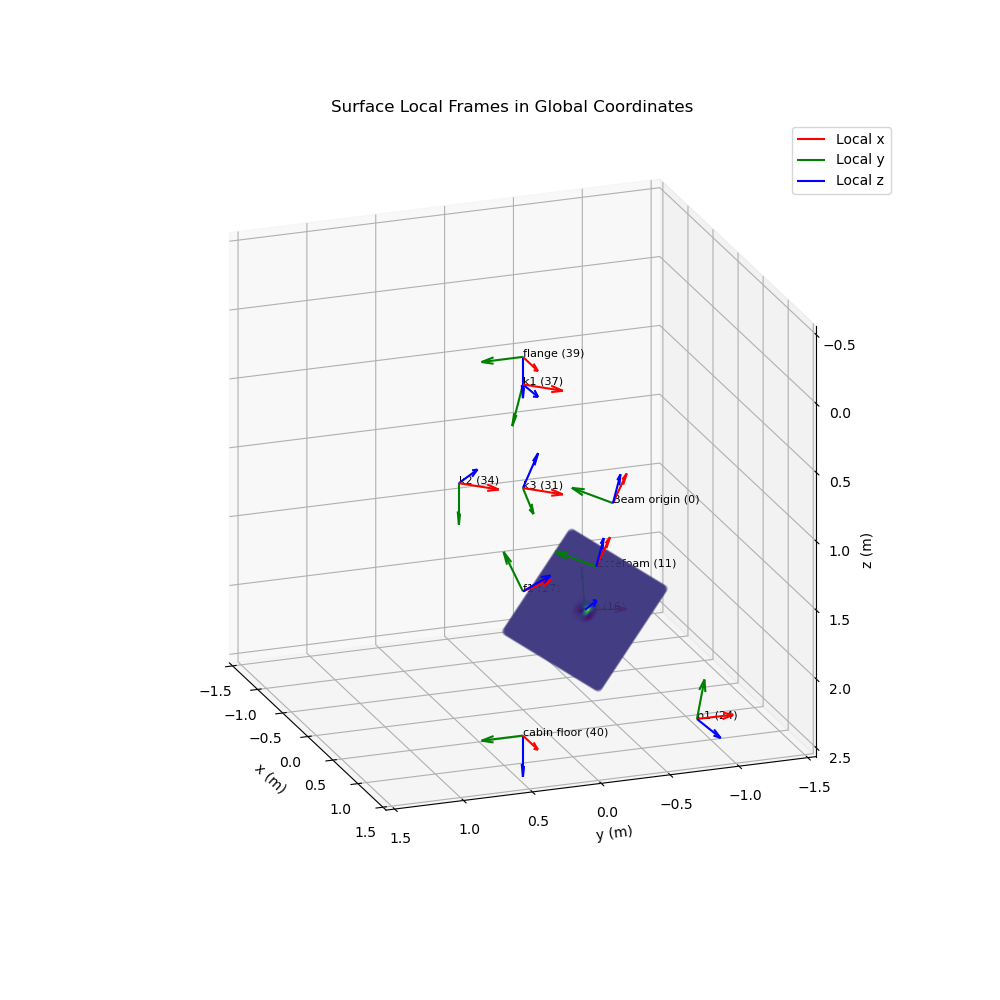

In [34]:
fig, ax = plot_important_surfaces(global_matrices, important_keys)

stride = 4
src_prime_grid = src_prime.reshape((xx.shape[0], xx.shape[1], 3))
ax.scatter(
    src_prime_grid[::stride, ::stride, 0],
    src_prime_grid[::stride, ::stride, 1],
    src_prime_grid[::stride, ::stride, 2],
    c=(src)[::stride,::stride],
    alpha=0.05,
)

## Calculate Fresnel Integral

In [35]:
@njit(parallel=True)
def E_fresnel(src, src_pts, pts, lambd):
    '''
    Calculate the Fresnel diffraction integral.
    
    The source field E(x',y',z') is stored in array src, the resulting diffracted field
    is calculated at each (x,y,z) point in array pts.

    Parameters
    ----------
    src : np.ndarray
        Source plane data
    src_pts : np.ndarray
        (N,3) array of x,y,z, points in the global frame on which lie the complex source data
    pts : np.ndarray
        (N,3) array of x,y,z, points in the global frame at which to calculate the diffraction integral
    lambd : float
        Operating wavelength, m

    Returns
    -------
    np.ndarray
        Fresnel diffraction pattern evaluated at pts
    '''
    A = 1. / (1j * lambd)
    k = 2. * np.pi / lambd
    e_fresnel = np.zeros(pts.shape[0], dtype=np.complex64)
    # for each point in the field
    for i in prange(len(pts)):
        x_dest, y_dest, z_dest = pts[i]
        # perform the fresnel integral over all source-field pairs
        res = np.zeros((src.shape[0], src.shape[1]), dtype=np.complex64)
        for ii in prange(src.shape[0]):
            for jj in prange(src.shape[1]):
                x_src = src_pts[jj+ii*src.shape[1]][0]
                y_src = src_pts[jj+ii*src.shape[1]][1]
                z_src = src_pts[jj+ii*src.shape[1]][2]
                r2 = (x_dest - x_src) ** 2. + (y_dest - y_src) ** 2. + (z_dest - z_src) ** 2.
                r = r2 ** .5
                res[ii][jj] = src[ii][jj] * np.exp(1j * k * r) * (z_dest - z_src) / r2
        # assumption: beam file pixels are square
        # side length = distance between adjacent points, d = sqrt((x'-x)^2 + (y'-y)^2 + (z'-z)^2)
        # area = (d)^2
        src_area_element = (
            (src_pts[1][0] - src_pts[0][0]) ** 2. +
            (src_pts[1][1] - src_pts[0][1]) ** 2. +
            (src_pts[1][2] - src_pts[0][2]) ** 2.
        )
        e_fresnel[i] = res.flatten().sum() * src_area_element # Riemann sum: \sum f(x,y) * dx * dy
    return A * e_fresnel

65


In [36]:
print(f'dimensionality: {dest_prime.shape[0] * src.shape[0] * src.shape[1]:,}')

if not os.path.exists(src_surf_name.upper() + '_to_' + dest_surf_name.upper() + '_results.npz'):
    fresnel_img_list = E_fresnel(src, src_prime, dest_prime, lambd)
    fresnel_img = fresnel_img_list.reshape(xx_img.shape)
    np.savez(src_surf_name.upper() + '_to_' + dest_surf_name.upper() + '_results.npz', xx_img=xx_img, yy_img=yy_img, fresnel_img=fresnel_img)
else:
    data = np.load(src_surf_name.upper() + '_to_' + dest_surf_name.upper() + '_results.npz')
    xx_img = np.real(data['xx_img'])
    yy_img = np.real(data['yy_img'])
    fresnel_img = data['fresnel_img']
    fresnel_img_list = fresnel_img.flatten()
    data.close()

66
dimensionality: 9,815,261,184


In [37]:
intensity = np.abs(fresnel_img_list) ** 2.
mean_intens = np.mean(intensity[intensity != 0])
phase = np.angle(fresnel_img_list)
phase[intensity < mean_intens / 100.] = 0

src_prime_grid = src_prime.reshape((xx.shape[0], xx.shape[1], 3))
dest_prime_grid = dest_prime.reshape((xx_img.shape[0], xx_img.shape[1], 3))
intensity_grid = intensity.reshape((xx_img.shape[0], xx_img.shape[1]))
phase_grid = phase.reshape((xx_img.shape[0], xx_img.shape[1]))

67


### Plot results

Text(0.5, 0.92, 'Surface Phase')

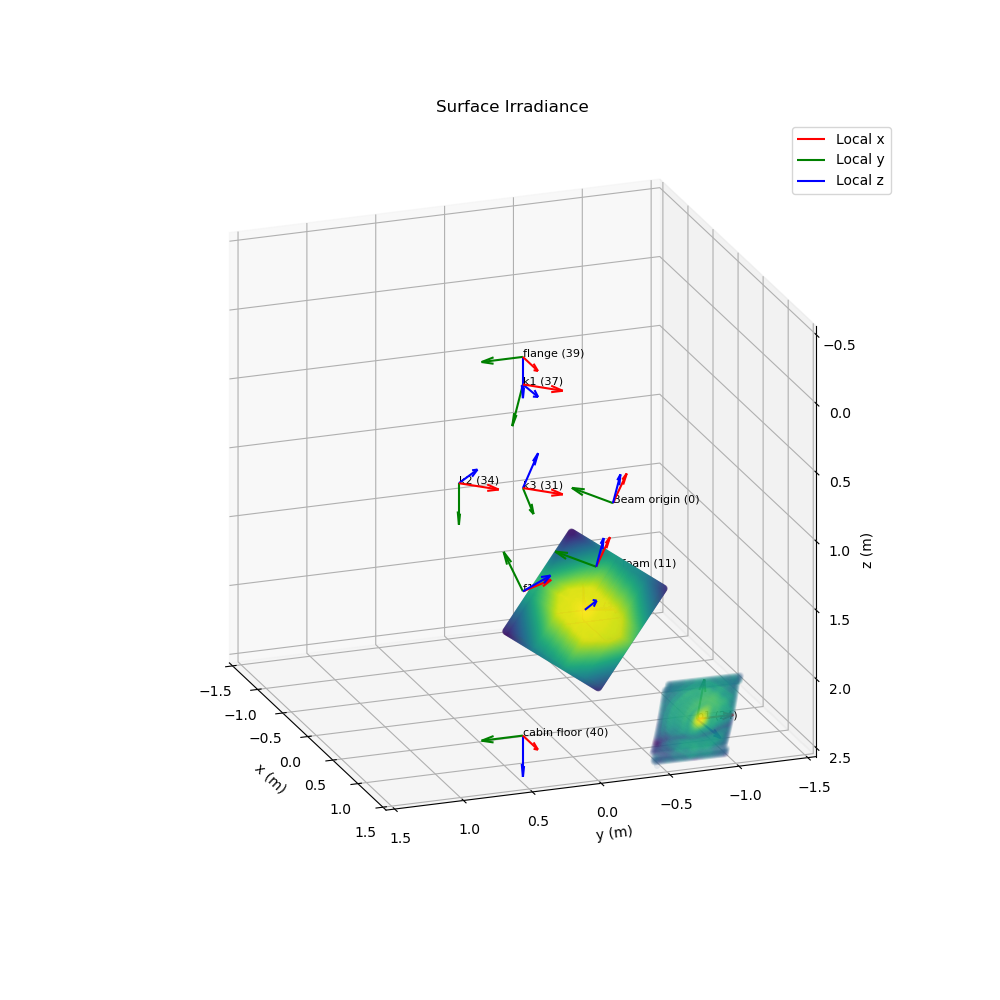

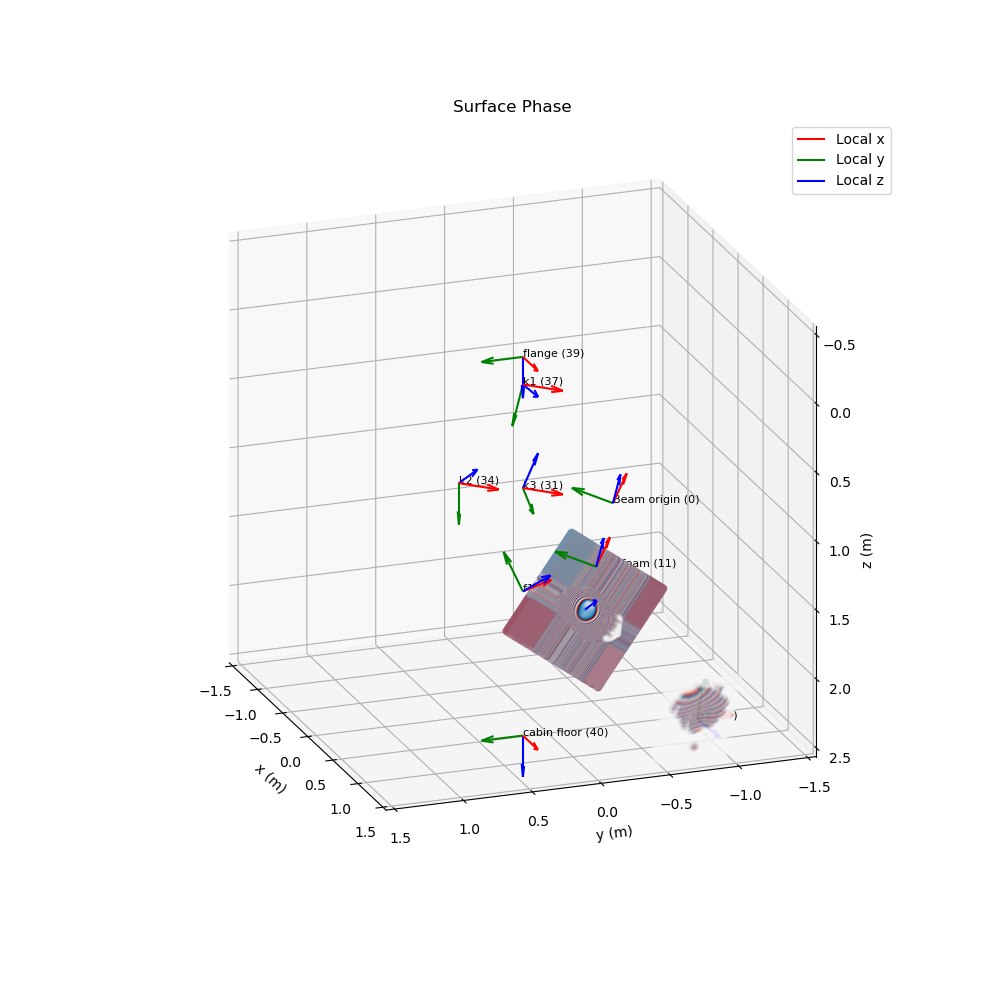

In [41]:
def mask_nans(arr):
    nan_mask = ~np.isnan(arr)
    return arr[nan_mask]

fig0, ax0 = plot_important_surfaces(global_matrices, important_keys)
stride = 2
ax0.scatter(
    src_prime_grid[::stride, ::stride, 0],
    src_prime_grid[::stride, ::stride, 1],
    src_prime_grid[::stride, ::stride, 2],
    c=mask_nans(np.log10(src[::stride,::stride])),
    edgecolor='none',
    alpha=0.1
)
ax0.scatter(
    dest_prime_grid[::stride, ::stride, 0],
    dest_prime_grid[::stride, ::stride, 1],
    dest_prime_grid[::stride, ::stride, 2],
    c=mask_nans(np.log10(intensity_grid[::stride,::stride])),
    edgecolor='none',
    alpha=0.1
)
ax0.set_title('Surface Irradiance')

fig1, ax1 = plot_important_surfaces(global_matrices, important_keys)
ax1.scatter(
    src_prime_grid[::stride, ::stride, 0],
    src_prime_grid[::stride, ::stride, 1],
    src_prime_grid[::stride, ::stride, 2],
    c=np.angle(src)[::stride,::stride],
    edgecolor='none',
    cmap='RdBu_r',
    alpha=0.1
)
ax1.scatter(
    dest_prime_grid[::stride, ::stride, 0],
    dest_prime_grid[::stride, ::stride, 1],
    dest_prime_grid[::stride, ::stride, 2],
    c=phase_grid[::stride,::stride],
    edgecolor='none',
    cmap='RdBu_r',
    alpha=0.1
)
ax1.set_title('Surface Phase')

# all_pts = np.vstack([src_prime, dest_prime])
# centroid = np.mean(all_pts, axis=0)
# vbox_size = 3
# for ax in [ax0, ax1]:
    # ax.set_xlim(centroid[0] + np.array([-vbox_size / 2, vbox_size / 2]) * u.m)
    # ax.set_ylim(centroid[1] + np.array([-vbox_size / 2, vbox_size / 2]) * u.m)
    # ax.set_zlim(centroid[2] + np.array([-vbox_size / 2, vbox_size / 2]) * u.m)

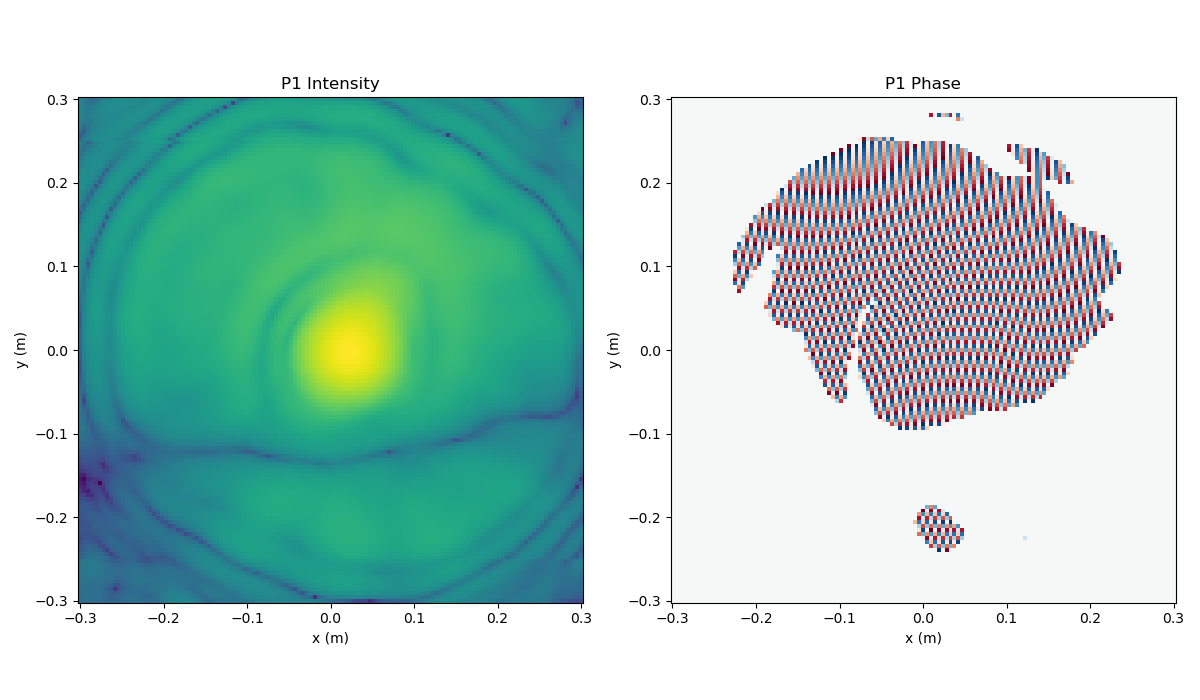

26
101


In [43]:
fig2, axs = plt.subplots(figsize=figsize, nrows=1, ncols=2)

stride = 1
axs[0].pcolormesh(
    xx_img[::stride, ::stride],
    yy_img[::stride, ::stride],
    np.log10(intensity_grid[::stride,::stride]),
)
axs[0].set_title(dest_surf_name.upper() + ' Intensity')
axs[1].pcolormesh(
    xx_img[::stride, ::stride],
    yy_img[::stride, ::stride],
    phase_grid[::stride,::stride],
    cmap='RdBu_r',
)
axs[1].set_title(dest_surf_name.upper() + ' Phase')
for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
fig2.tight_layout()

fig2.savefig(src_surf_name.upper() + '_to_' + dest_surf_name.upper() + '_results.png', dpi=400)

/home/evanmayer/miniconda3/envs/astr/lib/python3.9/site-packages/matplotlib/axes/_axes.py:4186: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


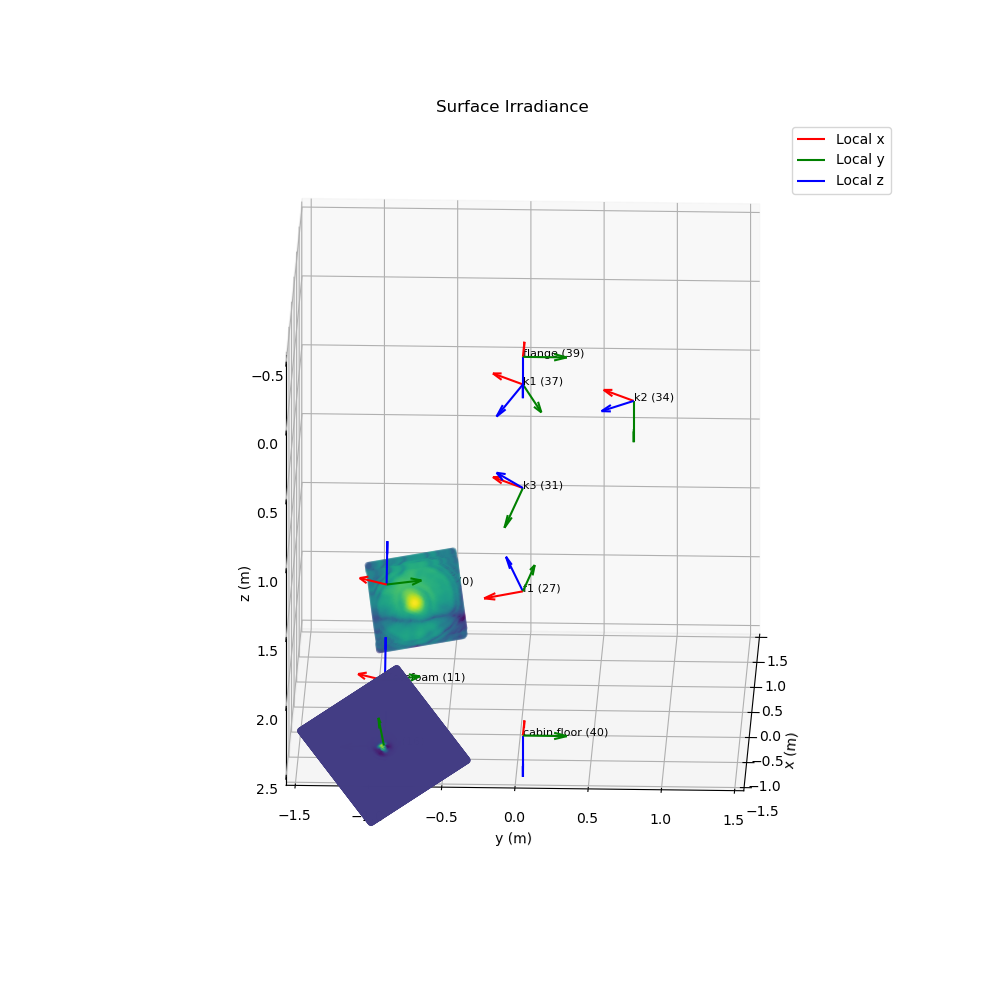

In [40]:
from matplotlib import animation

fig0, ax0 = plot_important_surfaces(global_matrices, important_keys)

def init():
    stride = 2
    ax0.scatter(
        src_prime_grid[::stride, ::stride, 0],
        src_prime_grid[::stride, ::stride, 1],
        src_prime_grid[::stride, ::stride, 2],
        c=mask_nans(np.log10(src[::stride,::stride])),
        edgecolor='none',
        alpha=0.5
    )
    ax0.scatter(
        dest_prime_grid[::stride, ::stride, 0],
        dest_prime_grid[::stride, ::stride, 1],
        dest_prime_grid[::stride, ::stride, 2],
        c=mask_nans(np.log10(intensity_grid[::stride,::stride])),
        edgecolor='none',
        alpha=0.5
    )
    ax0.set_title('Surface Irradiance')
    return fig0,


# https://stackoverflow.com/a/18345457
def animate(i):
    print(i)
    ax0.view_init(elev=-160., azim=2*i)
    return fig0,

anim = animation.FuncAnimation(fig0, animate, init_func=init,
                               frames=180, interval=200, blit=True)
writergif = animation.PillowWriter(fps=15)
anim.save(src_surf_name.upper() + '_to_' + dest_surf_name.upper() + '_results.gif', writer=writergif)